# Predicting Titanic Survival

From the description of a Kaggle Machine Learning Challenge at https://www.kaggle.com/c/titanic

> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy. 

In this demo we will use MLDB to train a classifier to predict whether a passenger would have survived the Titanic disaster.

## Initializing `pymldb` and other imports

In this demo, we will use `pymldb` to interact with the [REST API](../../../../doc/#builtin/WorkingWithRest.md.html): see the [Using `pymldb` Tutorial](../../../../doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [1]:
from pymldb import Connection
mldb = Connection("http://localhost")

#we'll need these also later!
import pandas as pd, matplotlib.pyplot as plt, seaborn, ipywidgets
%matplotlib inline

## Checking out the Titanic dataset

From https://www.kaggle.com/c/titanic

## Load up the data

See the [Loading Data Tutorial](../../../../doc/nblink.html#_tutorials/Loading Data Tutorial) guide for more details on how to get data into MLDB.

In [2]:
mldb.put('/v1/procedures/import_titanic_raw', { 
    "type": "import.text",
    "params": { 
        "dataFileUrl": "http://public.mldb.ai/titanic_train.csv",
        "outputDataset": "titanic_raw",
        "runOnCreation": True
    } 
})

<Response [201]>

## Let's look at the data

See the [Query API](../../../../doc/#builtin/sql/QueryAPI.md.html) documentation for more details on SQL queries.

In [3]:
mldb.query("select * from titanic_raw limit 5")

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,label,Cabin
_rowName,,,,,,,,,,,,
2,22,S,7.2500,BraundMr.OwenHarris,0,1,3,male,1,A/521171,0,None
3,38,C,71.2833,CumingsMrs.JohnBradley(FlorenceBriggsThayer),0,2,1,female,1,PC17599,1,C85
4,26,S,7.9250,HeikkinenMiss.Laina,0,3,3,female,0,STON/O2.3101282,1,None
5,35,S,53.1000,FutrelleMrs.JacquesHeath(LilyMayPeel),0,4,1,female,1,113803,1,C123
6,35,S,8.0500,AllenMr.WilliamHenry,0,5,3,male,0,373450,0,None


## Training a classifier


We will create a [Procedure](../../../../doc/#builtin/procedures/Procedures.md.html) of type [`classifier.experiment`](../../../../doc/#builtin/procedures/ExperimentProcedure.md.html).

In [4]:
result = mldb.put('/v1/procedures/titanic_train_scorer', {
    "type": "classifier.experiment",
    "params": {
        "experimentName": "titanic",
        "keepArtifacts": True,
        "inputData": """
            select 
                {Sex, Age, Fare, Embarked, Parch, SibSp, Pclass} as features,
                label
            from titanic_raw
        """,
        "modelFileUrlPattern": "file://models/titanic.cls",
        "algorithm": "bbdt",
        "outputAccuracyDataset": True,
        "equalizationFactor": 1,
        "runOnCreation": True
    }
})

auc = result.json()["status"]["firstRun"]["status"]["folds"][0]["resultsTest"]["auc"]
print "\nArea under ROC curve = %0.4f\n" % auc


Area under ROC curve = 0.8761



## We automatically get a REST API for predictions

The procedure above created for us a [Function](../../../../doc/#builtin/functions/Functions.md.html) of type [`classifier`](../../../../doc/#builtin/functions/ClassifierApply.md.html).

In [5]:
@ipywidgets.interact
def score( Age=[0,80],Embarked=["C", "Q", "S"], Fare=[1,100], Parch=[0,8], Pclass=[1,3], 
            Sex=["male", "female"], SibSp=[0,8]):
    return mldb.get('/v1/functions/titanic_scorer_0/application', input={"features": locals()})

<Response [200]>

## What's in a score?

NOTE: the interactive part of this demo only works if you're running this Notebook live, not if you're looking at a static copy on http://docs.mldb.ai. See the documentation for [Running MLDB](../../../../doc/#builtin/Running.md.html).

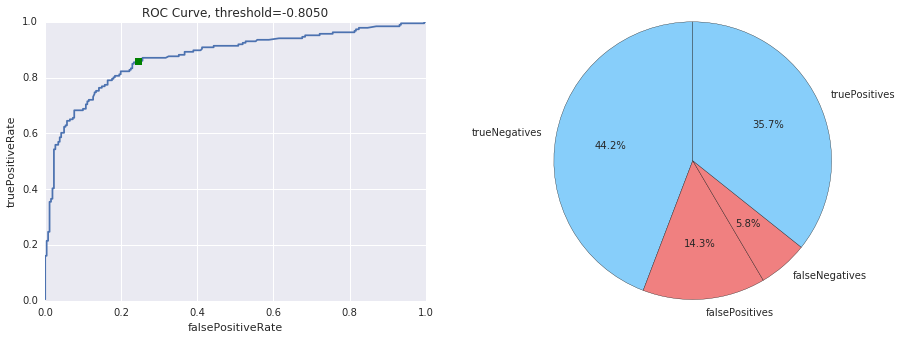

In [6]:
accuracy = mldb.query("select * from titanic_results_0 order by score desc")

@ipywidgets.interact
def accuracy_plot( threshold_index=[0,len(accuracy)-1]):
    row = accuracy.iloc[threshold_index]
    cols = ["trueNegatives","falsePositives","falseNegatives","truePositives",]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    accuracy.plot(ax=ax1, x="falsePositiveRate", y="truePositiveRate", 
    legend=False, title="ROC Curve, threshold=%.4f" % row.score).set_ylabel('truePositiveRate')
    ax1.plot(row.falsePositiveRate, row.truePositiveRate, 'gs')
    
    ax2.pie(row[cols], labels=cols, autopct='%1.1f%%', startangle = 90,
            colors=['lightskyblue','lightcoral','lightcoral', 'lightskyblue'])
    ax2.axis('equal')
    f.subplots_adjust(hspace=.75)
    plt.show()

## But what is the model doing under the hood?

Let's create a function of type [`classifier.explain`](../../../../doc/#builtin/functions/ClassifierExplain.md.html) to help us understand what's happening here.

In [7]:
mldb.put('/v1/functions/titanic_explainer', { 
    "id": "titanic_explainer", 
    "type": "classifier.explain",
    "params": { "modelFileUrl": "file://models/titanic.cls" }
})

<Response [201]>

## Exploring the impact of features for a single example

NOTE: the interactive part of this demo only works if you're running this Notebook live, not if you're looking at a static copy on http://docs.mldb.ai. See the documentation for [Running MLDB](../../../../doc/#builtin/Running.md.html).

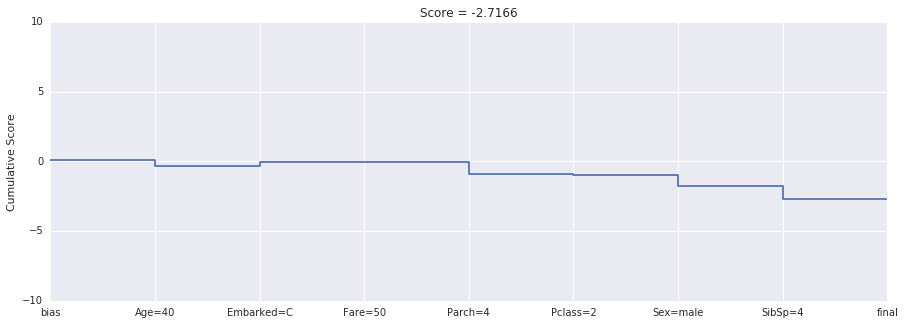

In [8]:
@ipywidgets.interact
def sliders( Age=[0,80],Embarked=["C", "Q", "S"], Fare=[1,100], Parch=[0,8], Pclass=[1,3], 
            Sex=["male", "female"], SibSp=[0,8]):
    features = locals()
    x = mldb.get('/v1/functions/titanic_explainer/application', input={"features": features, "label": 1}).json()["output"]
   
    df = pd.DataFrame(
        {"%s=%s" % (feat, str(features[feat])): val for (feat, (val, ts)) in x["explanation"]}, 
        index=["val"]).transpose().cumsum()
    pd.DataFrame(
        {"cumulative score": [x["bias"]]+list(df.val)+[df.val[-1]]}, 
        index=['bias'] + list(df.index) + ['final']
    ).plot(kind='line', drawstyle='steps-post', legend=False, figsize=(15, 5), 
           ylim=(-10, 10), title="Score = %.4f" % df.val[-1]).set_ylabel('Cumulative Score')
    
    plt.show()


## Summing up explanation values to get overall feature importance

When we sum up the explanation values in the context of the correct label, we can get an indication of how important each feature was to making a correct classification.

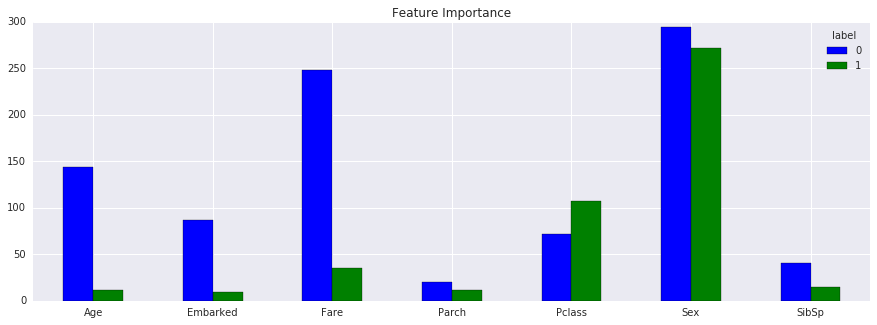

In [9]:
df = mldb.query("""
select label, sum(
    titanic_explainer({
        label: label, 
        features: {Sex, Age, Fare, Embarked, Parch, SibSp, Pclass}
    })[explanation]
) as *
from titanic_raw group by label
""")
df.set_index("label").transpose().plot(kind='bar', title="Feature Importance", figsize=(15, 5))
plt.xticks(rotation=0)
plt.show()

## We can also load up a custom UI for this

In [10]:
mldb.put('/v1/plugins/pytanic', {
    "type":"python",
    "params": {"address": "git://github.com/datacratic/mldb-pytanic-plugin"}
})

<Response [201]>

Now you can browse to [the plugin UI](../../../../v1/plugins/pytanic/routes/static/titanic.html).

NOTE: this only works if you're running this Notebook live, not if you're looking at a static copy on http://docs.mldb.ai. See the documentation for [Running MLDB](../../../../doc/#builtin/Running.md.html).

## Where to next?

Check out the other [Tutorials and Demos](../../../../doc/#builtin/Demos.md.html).